# Change in Kinetic Energy - THUG

### Imports

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from utils import logp as logp_scale
from Zappa.zappa import zappa_sampling_multivariate, zappa_sampling
from Zappa.ZappaStore import Zappa
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import quick_MVN_scatter, MVN_scatters, prep_contour
from numpy.random import rand
from numpy.linalg import norm, solve, inv, det
from scipy.optimize import fsolve, root
from Manifolds.Manifold import Manifold
from tangential_hug_functions import Hug, HugTangential, NoAR
from utils import quick_3d_scatter, quick_3d_scatters, quick_MVN_marginals
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

### Target Distribution

In [2]:
# Target is a MVN with mean `mu` and covariance `Sigma`
mu = np.zeros(2)                        
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)

# Functions for log pdf and **normalized** gradient of log pdf
logpi = target.logpdf
grad_log_pi = lambda xy: - solve(Sigma, xy)
def norm_grad_log_pi(xy):
    gradient = grad_log_pi(xy)
    return gradient / norm(gradient)

# Proposal distribution is a standard MVN
q = multivariate_normal(np.zeros(2), np.eye(2))

### THUG Function

In [3]:
def THUG(x0, v0s, delta, alpha, q, logpi, norm_grad_log_pi):
    g = norm_grad_log_pi(x0)         # Compute normalized gradient at x0
    v0 = v0s - alpha * g * (g @ v0s) # Tilt velocity
    v, x = v0, x0                    # Housekeeping

    # B = 1 to check what happens in 1 step
    x = x + delta*v/2           # Move to midpoint
    g = norm_grad_log_pi(x)     # Compute gradient at midpoint
    v = v - 2*(v @ g) * g       # Reflect velocity using midpoint gradient
    x = x + delta*v/2           # Move from midpoint to end-point
        
    # Unsqueeze the velocity
    g = norm_grad_log_pi(x)
    v = v + (alpha / (1 - alpha)) * g * (g @ v)
    return x, v   # Return SPHERICAL velocities

In [4]:
# Initial position and spherical velocity
x0 = target.rvs()
v0s = q.rvs()

# Settings
M = 50                                     # Number of times to average each run over
alphas = np.array([0.0, 0.3, 0.6, 0.9])    # Squeezing factors
deltas = np.array([1.0, 0.1, 0.01, 0.001, 0.0001]) # Step size

# Store absolute value of difference of logq. Rows are different deltas, columns are different alphas.
logpdf_diff = np.zeros((len(deltas), len(alphas)))

for ix, delta in enumerate(deltas):
    for jx, alpha in enumerate(alphas):
        avg = 0.0
        for i in range(M):
            _, v1 = THUG(x0, v0s, delta, alpha, q, logpi, norm_grad_log_pi)
            avg += np.abs(q.logpdf(v0s) - q.logpdf(v1)) / M
        logpdf_diff[ix, jx] = avg

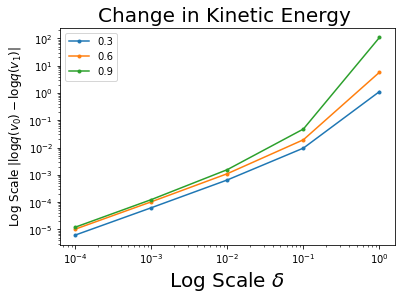

In [277]:
indeces = np.arange(len(alphas))[1:]
fig, ax = plt.subplots()
lines = ax.plot(deltas, logpdf_diff[:, indeces], marker='.')
ax.set_xlabel(r'Log Scale $\delta$', fontsize=20)
ax.set_ylabel("Log Scale " + r'$|\log q(v_0) - \log q(v_1)|$', fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Change in Kinetic Energy ", fontsize=20)
ax.legend(lines, alphas[indeces])
plt.show()

### Formula

Want to check wheather the formula below is correct.

$$
||v_1||^2 = ||v_0||^2 + \alpha(2-\alpha)\left(\left(\eta_\perp^1\right)^2 - \left(\eta_\perp^0\right)^2\right)
$$

$$
\eta_\perp^1 = {\gamma_\perp^1 \over (1 - \alpha)}
$$

$$
(a + \mathcal{O}(\delta))^2
$$

The only term above that depends on $\delta$ is $\eta_\perp^1$

In [14]:
a = 0.9   # alpha
d = 0.01  # delta
x, v = THUG(x0, v0s, d, a, q, logpi, norm_grad_log_pi)

In [15]:
def formula(v0s, alpha, eta_perp_0, eta_perp_1):
    """Uses the formula above to compute the norm of the new velocity after 1 step."""
    return norm(v0s)**2 + alpha*(2-alpha)*(eta_perp_1**2 - eta_perp_0**2)

In [16]:
def J(x):
    g = grad_log_pi(x)
    ghat = g / norm(g)
    return (np.eye(2) - np.outer(ghat, ghat)) @ H / norm(g)

In [17]:
# Gradient at x0
g0 = norm_grad_log_pi(x0)
# Components of v0 along g0
eta_perp_0 = g0 @ v0s
eta_para_0 = np.sqrt(norm(v0s)**2 - eta_perp_0**2)
# Tangent vector at x0
t0 = (v0s - eta_perp_0 * g0) / eta_para_0

# Gradient at x1
g1 = norm_grad_log_pi(x)
# Components of unsqueezed velocity
eta_perp_1 = g1 @ v
eta_para_1 = np.sqrt(norm(v)**2 - eta_perp_1**2)
# Tangent at x1
t1 = (v - eta_perp_1*g1) / eta_para_1

# Compute squeezed velocity
w0 = v0s - a * eta_perp_0 * g0
# Compute midpoint
x_half = x0 + (d/2)*w0
# Midpoint gradient
g_half = norm_grad_log_pi(x_half)
g_half_unnormalized = grad_log_pi(x_half)
g_half_norm = norm(g_half_unnormalized)

# Reflect squeezed velocity
w1 = w0 - 2*g_half * (g_half @ w0)
# Hessian
H = -inv(Sigma)
# Gamma at endpoint
gamma_perp_1 = eta_perp_1 * (1-a)

In [18]:
formula(v0s, a, eta_perp_0, eta_perp_1) - norm(v)**2

8.881784197001252e-16

In [19]:
approx1 = - w0 @ g_half + (d / (2 * g_half_norm)) * w0 @ [H + np.outer(g_half, g_half) @ H *[-3*np.eye(2) + np.outer(g_half, g_half)]] @ w0

In [20]:
approx1[0,0] - gamma_perp_1

0.017838439763577643

In [21]:
(- w0 @ g_half + (d/2)* w0 @ J(x_half) @ w1) #- gamma_perp_1

0.04134400604994393

In [22]:
v0s @ J(x0)

array([ 0.39061561, -0.95835843])

In [23]:
v0s @ (-inv(Sigma)) / norm(grad_log_pi(x0))

array([-0.60697233, -0.38595324])

# Testing if third order term disappears (HUG)

In [24]:
delta = 0.1

In [25]:
g0 = norm_grad_log_pi(x0)
v0 = multivariate_normal(np.zeros(2), np.eye(2)).rvs()
x_half = x0 + (delta/2) * v0
g_half = norm_grad_log_pi(x_half)

In [26]:
g_half @ g0

0.9995537274819732

In [27]:
1 - delta**3

0.999

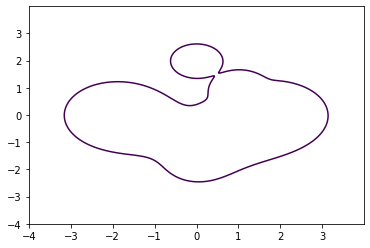

In [28]:
### Parameters of Mixture
# Means
mus = np.array([
    [0, 0],
    [2, 0],
    [0, 2],
    [-2, 0],
    [0, -2],
    [1, 1]
])
# Covariances
Sigmas = np.stack([
    3.0 * np.eye(2),
    1.0 * np.eye(2),
    0.05 * np.eye(2),
    0.5 * np.eye(2),
    2.0 * np.eye(2),
    0.05 * np.eye(2)
])
# Mixture coefficients are all the same
d = mus.shape[0]
coefs = np.repeat(1/d, d)

# Gaussian Components
distributions = [multivariate_normal(mu, Sigma) for (mu, Sigma) in zip(mus, Sigmas)]

# Mixture, log mixture, grad of log mixture
MG = lambda xy: np.sum(np.vstack([c * MVN.pdf(xy)  for (c, MVN) in zip(coefs, distributions)]), axis=0)
logpi = lambda xy: np.log(MG(xy))
grad_log_pi = lambda xy: (1 / MG(xy)) * np.sum(np.vstack([- c * multivariate_normal(mu, Sigma).pdf(xy) * solve(Sigma, xy - mu) for (c, mu, Sigma) in zip(coefs, mus, Sigmas)]), axis=0)
def norm_grad_log_pi(xy):
    g = grad_log_pi(xy)
    return g / norm(g)

# Find an odd contour
z = 0.016   # Sharp Turn: 0.016, Softer Turn: 0.004
plt.contour(*prep_contour([-4, 4], [-4, 4], 0.01, MG), levels=[z])
plt.show()

In [29]:
# Find starting point on contour
starting_guess = np.array([0.0, -2.5]) # Near Hook: np.array([-0.1, 2.5])
x0 = fsolve(lambda xy: np.append(MG(xy) - z, 0), starting_guess)

In [30]:
delta = 0.1
g0 = norm_grad_log_pi(x0)
v0 = multivariate_normal(np.zeros(2), np.eye(2)).rvs()
x_half = x0 + (delta/2) * v0
g_half = norm_grad_log_pi(x_half)

In [31]:
g_half @ g0

0.9999849956714317

In [32]:
1 -delta**4

0.9999

Seems like third order term disappears.

# Test Approximation

In [145]:
a = 0.9   # alpha
d = 0.01  # delta
x0 = target.rvs()
v0s = q.rvs()
x, v = THUG(x0, v0s, d, a, q, logpi, norm_grad_log_pi)

In [146]:
def compute_all(a, d, x0, v0s):
    ### t = 0
    # Gradient at 0
    g0 = grad_log_pi(x0)
    g0_norm = norm(g0)
    g0_hat = g0 / g0_norm
    # Components of v0s at 0
    eta_perp_0 = g0_hat @ v0s
    eta_para_0 = np.sqrt(norm(v0s)**2 - eta_perp_0**2)
    # Tangent at 0
    t0 = (v0s - eta_perp_0 * g0_hat) / eta_para_0
    # Squeeze
    w0 = v0s - a * eta_perp_0 * g0_hat
    
    ### t = 1/2
    x_half = x0 + (d/2) * w0
    g_half = grad_log_pi(x_half)
    g_half_norm = norm(g_half)
    g_half_hat = g_half / g_half_norm
    gamma_perp_half = g_half_hat @ w0
    w1 = w0 - 2 * gamma_perp_half * g_half_hat
    
    # t = 1
    x1 = x_half + (d/2) * w1
    g1 = grad_log_pi(x1)
    g1_norm = norm(g1)
    g1_hat = g1 / g1_norm
    gamma_perp_1 = g1_hat @ w1
    v1 = w1 + (a/(1-a)) * gamma_perp_1 * g1_hat
    eta_perp_1 = g1_hat @ v1
    out = {
        'g0': g0,
        'g0_norm':g0_norm,
        'g0_hat':g0_hat,
        'eta_perp_0':eta_perp_0,
        'eta_para_0':eta_para_0,
        't0':t0,
        'w0':w0,
        'x_half':x_half,
        'g_half':g_half,
        'g_half_norm':g_half_norm,
        'g_half_hat':g_half_hat,
        'gamma_perp_half':gamma_perp_half,
        'w1':w1,
        'x1':x1,
        'g1':g1,
        'g1_norm':g1_norm, 
        'g1_hat':g1_hat,
        'gamma_perp_1':gamma_perp_1,
        'eta_perp_1': eta_perp_1, 
        'v1':v1
    }
    return out

In [100]:
# Gradient at x0
g0 = norm_grad_log_pi(x0)

# Components of v0 along g0
eta_perp_0 = g0 @ v0s
eta_para_0 = np.sqrt(norm(v0s)**2 - eta_perp_0**2)

# Tangent vector at x0
t0 = (v0s - eta_perp_0 * g0) / eta_para_0

# Hessian
H = -inv(Sigma)

# Gradient at x1
g1 = norm_grad_log_pi(x)
# Components of unsqueezed velocity
eta_perp_1 = g1 @ v
eta_para_1 = np.sqrt(norm(v)**2 - eta_perp_1**2)
# Tangent at x1
t1 = (v - eta_perp_1*g1) / eta_para_1

# Compute squeezed velocity
w0 = v0s - a * eta_perp_0 * g0
# Compute midpoint
x_half = x0 + (d/2)*w0
# Midpoint gradient
g_half = norm_grad_log_pi(x_half)
g_half_unnormalized = grad_log_pi(x_half)
g_half_norm = norm(g_half_unnormalized)

# Reflect squeezed velocity
w1 = w0 - 2*g_half * (g_half @ w0)

In [202]:
o = compute_all(a, d, x0, v0s)

In [203]:
norm(o['v1'])**2 - norm(v0s)**2

0.007775403754381571

In [204]:
# Formula
a * (2 - a) * (o['eta_perp_1']**2 - o['eta_perp_0']**2)

0.007775403754381665

In [205]:
# This is what gamma_perp_1 should be
o['eta_perp_1']**2 * ((1-a)**2)

0.01160528793650465

In [206]:
# And indeed it is
o['gamma_perp_1']**2

0.011605287936504654

In [212]:
# Definition of gamma_perp_1 squared
(o['g1_hat'] @ o['w1'])**2

0.011605287936504654

In [208]:
o['gamma_perp_1']

-0.10772784197460122

In [209]:
my_gamma1 = -(1-a) * o['eta_perp_0'] * (1 + d * o['eta_para_0'] * o['t0'] @ H @ o['g0_hat'] / o['g0_norm'])

In [226]:
# Difference between true and my gamma1
o['gamma_perp_1'] - my_gamma1

-0.0005905093267006556

In [241]:
# Difference between true and my gamma1 SQUARED
o['gamma_perp_1']**2,  my_gamma1**2

(0.011605287936504654, 0.011478408046906901)

In [232]:
# Eta_1_perp SQUARED
o['eta_perp_1']**2, my_gamma1**2 / (1-a)**2

(1.1605287936504656, 1.1478408046906907)

In [243]:
1 / (1 - a)**2

100.00000000000006

In [239]:
# TRUE eta perp 1
o['gamma_perp_1']**2 / (1-a)**2, o['eta_perp_1']**2

(1.160528793650466, 1.1605287936504656)

In [244]:
# My eta perp 1
my_gamma1**2 / (1-a)**2, (o['eta_perp_0']**2) * (1 + d * o['eta_para_0'] * o['t0'] @ H @ o['g0_hat'] / o['g0_norm'])**2

(1.1478408046906907, 1.1478408046906907)

In [245]:
my_eta1_sq = my_gamma1**2 / (1-a)**2

In [247]:
# Difference in eta1 squared
o['eta_perp_1']**2 - my_eta1_sq

0.012687988959774854

In [250]:
o['eta_perp_1']**2, my_eta1_sq

(1.1605287936504656, 1.1478408046906907)

In [253]:
# TRUE ONE
true_diff = a * (2 - a) * (o['eta_perp_1']**2 - o['eta_perp_0']**2)
true_diff

0.007775403754381665

In [252]:
o['eta_perp_0']**2

1.1526748504642215

In [254]:
my_diff = a * (2 - a) * (my_eta1_sq - o['eta_perp_0']**2)
my_diff

-0.004785705315795441

In [255]:
true_diff - my_diff

0.012561109070177106

In [260]:
my_diff2 = 2*d*a*(2-a)*(o['eta_perp_0']**2)*o['eta_para_0']*o['t0']@H@o['g0_hat']/o['g0_norm']

In [261]:
true_diff - my_diff2

0.012566137148130062

In [215]:
(((1-a)*o['eta_perp_0'])**2)*(1 + d*o['eta_para_0']*o['t0']@H@o['g0_hat']/o['g0_norm'])**2

0.011478408046906901

In [216]:
d, d**2

(0.01, 0.0001)

In [217]:
a*(2-a)*(my_gamma1**2/(1-a)**2 - o['eta_perp_0']**2)

-0.004785705315795441

In [218]:
a*(2-a)*(o['gamma_perp_1']**2/(1-a)**2 - o['eta_perp_0']**2)

0.007775403754382105

In [219]:
my_eta1_sq = ((o['eta_perp_0'])**2)*(1 + d*o['eta_para_0']*o['t0']@H@o['g0_hat']/o['g0_norm'])**2

In [220]:
a*(2-a)*(my_eta1_sq - o['eta_perp_0']**2)

-0.004785705315795441

In [222]:
a*(2-a)*(o['eta_perp_0']**2)*((1+d*o['eta_para_0']*o['t0']@H@o['g0_hat']/o['g0_norm'])**2 - 1)

-0.004785705315795529

In [189]:
2*d*a*(2-a)*(o['eta_perp_0']**2)*o['eta_para_0']*o['t0']@H@o['g0_hat']/(o['g0_norm'])

-0.004790733393748398

In [ ]:
# Approximation of x1


In [144]:
2 * d * a * (2 - a) * (o['eta_perp_0']**2) * o['eta_para_0'] * (o['t0'] @ H @ o['t0']) / norm(grad_log_pi(x0)) 

-0.06763521430985016

In [103]:
gamma_1_sq = (-(1-a)*eta_perp_0 * (1 + d*eta_para_0* (t0@H@t0)/norm(grad_log_pi(x0))))**2

In [105]:
a*(2-a)*((gamma_1_sq/((1-a)**2)) - eta_perp_0**2)

-0.06528993994839724

In [95]:
(w1 @ g1)**2

0.005339014975141974